# SHAP Analysis for AQI Prediction Models

This notebook performs SHAP (SHapley Additive exPlanations) analysis to interpret the machine learning models used for 72-hour AQI prediction.

SHAP values help us understand:
- Which features have the most impact on predictions
- How each feature contributes to individual predictions
- The direction of feature influence (positive or negative)

**Models Analyzed:**
- XGBoost Classifier
- Random Forest Classifier
- Support Vector Machine (SVM)

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import pickle
from io import BytesIO
import os
from dotenv import load_dotenv
from pymongo import MongoClient

# Enable SHAP plots in notebook
shap.initjs()

load_dotenv()

/home/hypxr/Repositories/AQI-Predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## 1. Connect to MongoDB and Load Data

In [2]:
# MongoDB connection
MONGODB_USERNAME = os.getenv("MONGODB_USERNAME")
MONGODB_PASSWORD = os.getenv("MONGODB_PASSWORD")
MONGODB_CLUSTER = os.getenv("MONGODB_CLUSTER")

CONNECTION_STRING = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/"
client = MongoClient(CONNECTION_STRING)
db = client["aqi_prediction"]

print("✓ Connected to MongoDB")

✓ Connected to MongoDB


In [3]:
# Load data from feature store
feature_store = db["feature_store"]
cursor = feature_store.find({}, {"_id": 0})
df = pd.DataFrame(list(cursor))
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"✓ Loaded {len(df)} records from feature store")
df.head()

✓ Loaded 2880 records from feature store


,timestamp,year,day,hour,epa_aqi,pm2_5,pm10,co,no2,so2,o3,temp_c,humidity_pct,pressure_hpa,wind_speed_kmh,wind_dir_deg,rain_mm,solar_rad_wm2,inserted_at,month
0,1.760382e+09,2025.0,14.0,0.0,3.0,30.06,76.43,132.01,0.13,1.12,102.17,25.0,78.0,1012.4,7.7,309.0,0.0,0.0,2026-01-25 07:30:56.738,10.0
1,1.760386e+09,2025.0,14.0,1.0,3.0,30.02,75.86,132.20,0.12,1.08,102.21,24.4,80.0,1011.9,7.8,328.0,0.0,0.0,2026-01-25 07:30:56.738,10.0
2,1.760389e+09,2025.0,14.0,2.0,3.0,29.89,75.19,132.14,0.11,1.05,102.36,24.2,80.0,1011.7,8.0,329.0,0.0,0.0,2026-01-25 07:30:56.738,10.0
3,1.760393e+09,2025.0,14.0,3.0,3.0,29.69,74.42,132.16,0.11,1.03,103.03,24.1,79.0,1011.2,8.6,324.0,0.0,0.0,2026-01-25 07:30:56.738,10.0
4,1.760396e+09,2025.0,14.0,4.0,3.0,29.34,72.96,131.86,0.11,1.03,104.51,23.9,81.0,1011.0,9.5,333.0,0.0,0.0,2026-01-25 07:30:56.738,10.0


## 2. Load Best Model from Registry

In [4]:
def load_model_from_registry(model_type=None):
    """Load a model from MongoDB model registry
    
    Args:
        model_type: 'xgboost', 'random_forest', or 'svm'. If None, loads best model.
    """
    registry = db["model_registry"]
    
    query = {'status': 'active'}
    if model_type:
        query['model_type'] = model_type
    
    doc = registry.find_one(
        query,
        sort=[('accuracy', -1), ('training_date', -1)]
    )
    
    if not doc:
        raise ValueError(f"No model found with type: {model_type}")
    
    model = pickle.load(BytesIO(doc['model_binary']))
    scaler = pickle.load(BytesIO(doc['scaler_binary']))
    
    return {
        'model': model,
        'scaler': scaler,
        'model_name': doc.get('model_name', 'Unknown'),
        'model_type': doc.get('model_type', 'unknown'),
        'feature_cols': doc.get('features', []),
        'accuracy': doc.get('accuracy', 0.0),
        'training_date': doc.get('training_date')
    }

# Load all three models
model_types = ['xgboost', 'random_forest', 'svm']
models = {}

for model_type in model_types:
    try:
        models[model_type] = load_model_from_registry(model_type)
        print(f"✓ Loaded {model_type}: {models[model_type]['model_name']}")
        print(f"  Accuracy: {models[model_type]['accuracy']:.4f}")
    except Exception as e:
        print(f"✗ Could not load {model_type}: {e}")

print(f"\n✓ Successfully loaded {len(models)} models")

/tmp/ipykernel_5178/2560195657.py:21: UserWarning: [19:42:44] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  model = pickle.load(BytesIO(doc['model_binary']))


✓ Loaded xgboost: XGBoost Classifier (72h forecast)
  Accuracy: 0.5239
✓ Loaded random_forest: Random Forest Classifier (72h forecast)
  Accuracy: 0.5157
✓ Loaded svm: Support Vector Machine (72h forecast)
  Accuracy: 0.6520

✓ Successfully loaded 3 models


## 3. Prepare Data for SHAP Analysis

In [5]:
# Get feature columns from loaded models (they should be the same)
first_model = list(models.values())[0]
feature_cols = first_model['feature_cols']

print(f"Features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Features (15):
  1. pm2_5
  2. pm10
  3. co
  4. no2
  5. so2
  6. o3
  7. temp_c
  8. humidity_pct
  9. pressure_hpa
  10. wind_speed_kmh
  11. wind_dir_deg
  12. rain_mm
  13. solar_rad_wm2
  14. hour
  15. month


In [6]:
# Prepare features
X = df[feature_cols].dropna()

# Use the first model's scaler (all models should use the same scaler)
scaler = first_model['scaler']
X_scaled = scaler.transform(X)

# Create DataFrame with scaled values for better visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"✓ Prepared {len(X)} samples for SHAP analysis")

✓ Prepared 2880 samples for SHAP analysis


## 4. SHAP Analysis for All Models

We'll compute SHAP values for each model and compare their feature importance.

In [7]:
# Calculate SHAP values for all models
sample_size = min(300, len(X_scaled_df))
X_sample = X_scaled_df.sample(n=sample_size, random_state=42)
X_sample_original = X.iloc[X_sample.index]  # Keep original values for display

# Background data for KernelExplainer (SVM)
background = shap.sample(X_scaled_df, min(100, len(X_scaled_df)))

shap_results = {}

for model_type, model_info in models.items():
    print(f"\n{'='*50}")
    print(f"Computing SHAP values for: {model_type.upper()}")
    print(f"{'='*50}")
    
    model = model_info['model']
    
    try:
        if model_type in ['xgboost', 'random_forest']:
            # TreeExplainer is fast and exact for tree-based models
            explainer = shap.TreeExplainer(model)
            print("  Using TreeExplainer (exact)")
        else:
            # KernelExplainer for SVM (model-agnostic but slower)
            explainer = shap.KernelExplainer(model.predict, background)
            print("  Using KernelExplainer (model-agnostic)")
        
        shap_values = explainer.shap_values(X_sample)
        
        # Calculate mean absolute SHAP values (ensure 1D array)
        if isinstance(shap_values, list):
            # Multi-class: average across all classes, then across samples
            # Each element in list is (n_samples, n_features)
            stacked = np.stack([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
            mean_shap = stacked.mean(axis=0)  # Average across classes
        else:
            # Single output or regression
            if shap_values.ndim > 2:
                # Shape is (n_samples, n_features, n_classes) - some explainers return this
                mean_shap = np.abs(shap_values).mean(axis=(0, 2))
            else:
                mean_shap = np.abs(shap_values).mean(axis=0)
        
        # Ensure it's a 1D array
        mean_shap = np.array(mean_shap).flatten()
        
        shap_results[model_type] = {
            'explainer': explainer,
            'shap_values': shap_values,
            'mean_shap': mean_shap,
            'accuracy': model_info['accuracy']
        }
        
        print(f"  ✓ SHAP values computed successfully")
        print(f"  Mean SHAP shape: {mean_shap.shape}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        import traceback
        traceback.print_exc()

print(f"\n✓ Computed SHAP values for {len(shap_results)} models")


Computing SHAP values for: XGBOOST
  Using TreeExplainer (exact)
  ✓ SHAP values computed successfully
  Mean SHAP shape: (15,)

Computing SHAP values for: RANDOM_FOREST
  Using TreeExplainer (exact)
  ✓ SHAP values computed successfully
  Mean SHAP shape: (15,)

Computing SHAP values for: SVM
  Using KernelExplainer (model-agnostic)


100%|██████████| 300/300 [57:13<00:00, 11.44s/it] 

  ✓ SHAP values computed successfully
  Mean SHAP shape: (15,)

✓ Computed SHAP values for 3 models


## 5. SHAP Visualizations

### 5.1 Feature Importance Comparison Across All Models
Compare which features are most important for each model.

xgboost: mean_shap shape = (15,), expected = (15,)
random_forest: mean_shap shape = (15,), expected = (15,)
svm: mean_shap shape = (15,), expected = (15,)

Feature Importance Comparison (Mean |SHAP|):

       feature  xgboost  random_forest      svm  average
         month 0.646642       0.044622 0.147483 0.279582
            co 0.493002       0.037293 0.116932 0.215742
            o3 0.392267       0.028837 0.203483 0.208196
           so2 0.294231       0.030161 0.233140 0.185844
         pm2_5 0.314385       0.023594 0.203710 0.180563
          pm10 0.332491       0.020260 0.151769 0.168173
  pressure_hpa 0.306358       0.025597 0.057789 0.129915
wind_speed_kmh 0.258484       0.011110 0.060570 0.110055
  wind_dir_deg 0.244911       0.011780 0.051917 0.102869
  humidity_pct 0.197274       0.010237 0.092254 0.099922
           no2 0.226038       0.017457 0.052804 0.098766
        temp_c 0.175674       0.009955 0.088440 0.091356
          hour 0.101319       0.007235 0.039476 0.049343


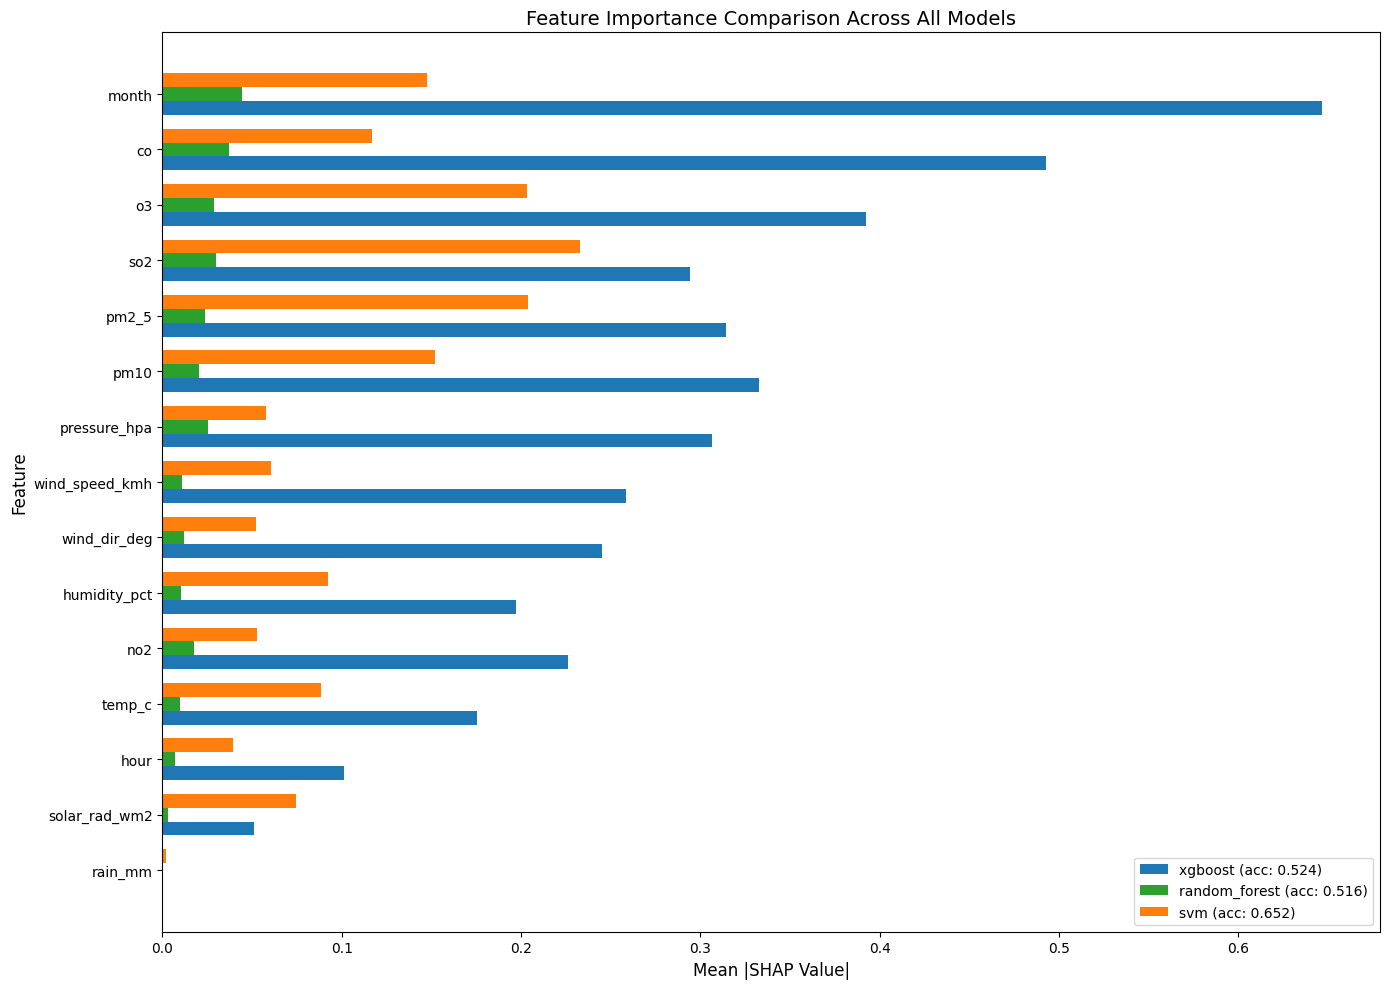

In [8]:
# Create comparison DataFrame
comparison_data = {'feature': feature_cols}

# Verify shapes before adding
for model_type, results in shap_results.items():
    mean_shap = results['mean_shap']
    print(f"{model_type}: mean_shap shape = {mean_shap.shape}, expected = ({len(feature_cols)},)")
    assert len(mean_shap) == len(feature_cols), f"Shape mismatch for {model_type}"
    comparison_data[model_type] = mean_shap

comparison_df = pd.DataFrame(comparison_data)
comparison_df['average'] = comparison_df[list(shap_results.keys())].mean(axis=1)
comparison_df = comparison_df.sort_values('average', ascending=False)

print("\nFeature Importance Comparison (Mean |SHAP|):\n")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 10))
x = np.arange(len(feature_cols))
width = 0.25
colors = {'xgboost': '#1f77b4', 'random_forest': '#2ca02c', 'svm': '#ff7f0e'}

comparison_sorted = comparison_df.sort_values('average', ascending=True)

for i, (model_type, results) in enumerate(shap_results.items()):
    offset = (i - len(shap_results)/2 + 0.5) * width
    ax.barh(x + offset, comparison_sorted[model_type], width, 
            label=f"{model_type} (acc: {results['accuracy']:.3f})", 
            color=colors.get(model_type, f'C{i}'))

ax.set_yticks(x)
ax.set_yticklabels(comparison_sorted['feature'])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance Comparison Across All Models', fontsize=14)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../docs/shap_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.2 Summary Plots for Each Model
Beeswarm plots showing SHAP value distributions for each model.

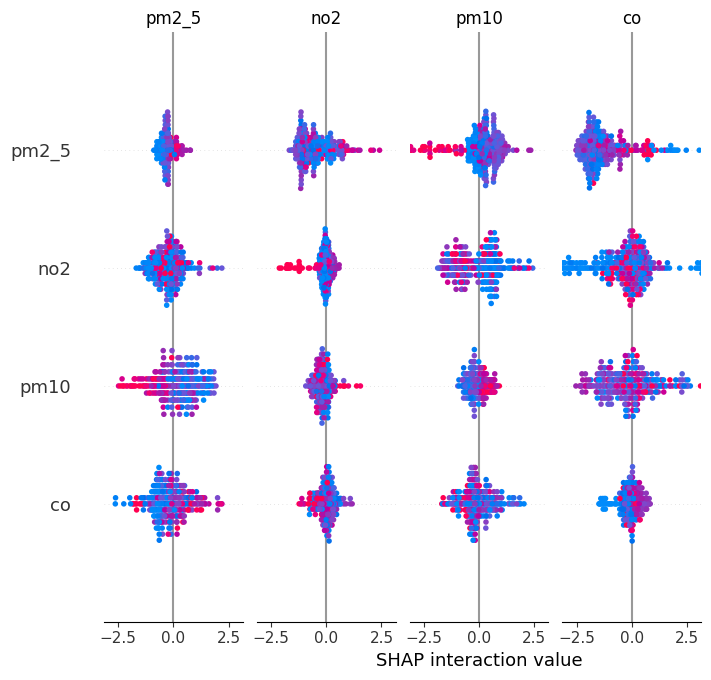

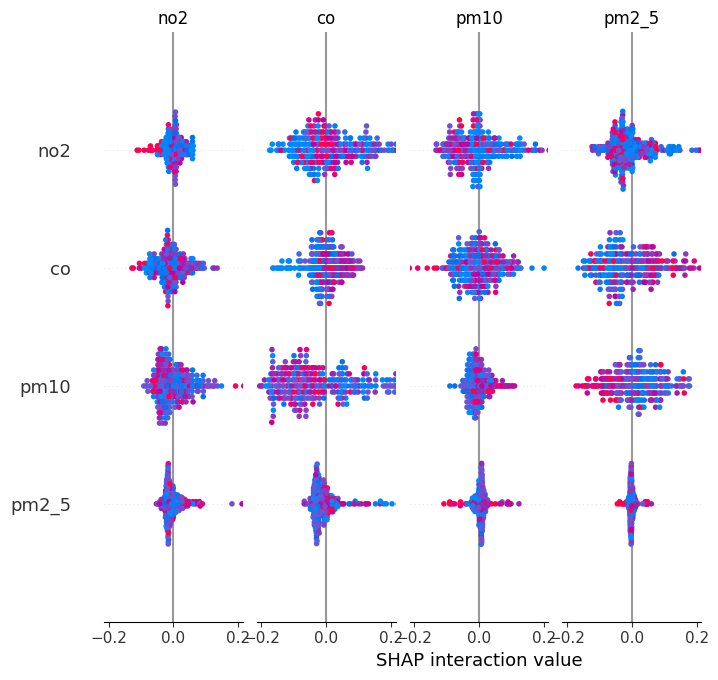

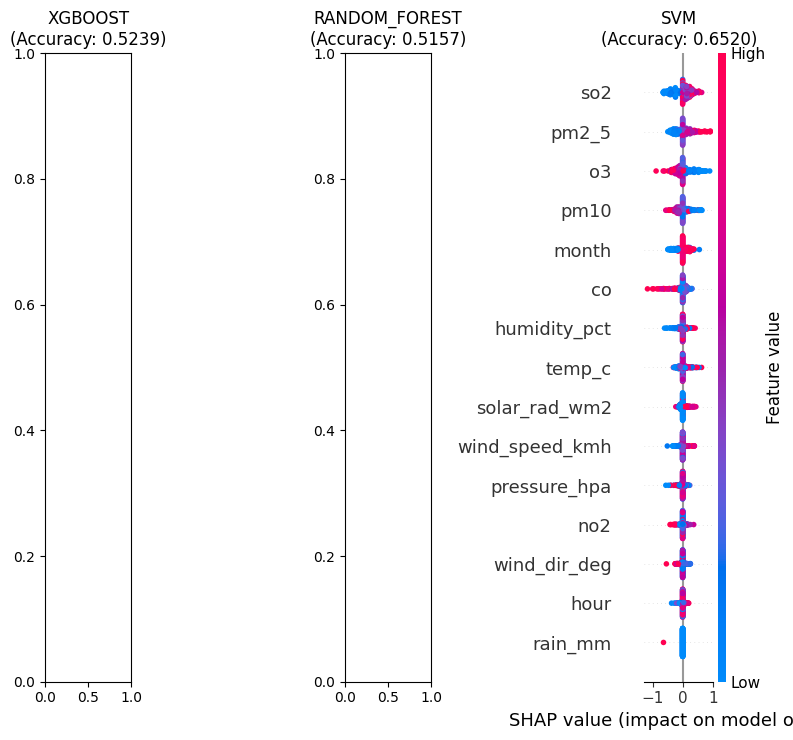

In [9]:
# Create summary plots for each model
n_models = len(shap_results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
if n_models == 1:
    axes = [axes]

for idx, (model_type, results) in enumerate(shap_results.items()):
    plt.sca(axes[idx])
    shap_values = results['shap_values']
    
    if isinstance(shap_values, list):
        # Multi-class: show one class or aggregate
        class_idx = min(2, len(shap_values) - 1)
        shap.summary_plot(shap_values[class_idx], X_sample, show=False)
    else:
        shap.summary_plot(shap_values, X_sample, show=False)
    
    axes[idx].set_title(f"{model_type.upper()}\n(Accuracy: {results['accuracy']:.4f})", fontsize=12)

plt.tight_layout()
plt.savefig('../docs/shap_summary_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Individual Model Feature Importance (Bar Plots)

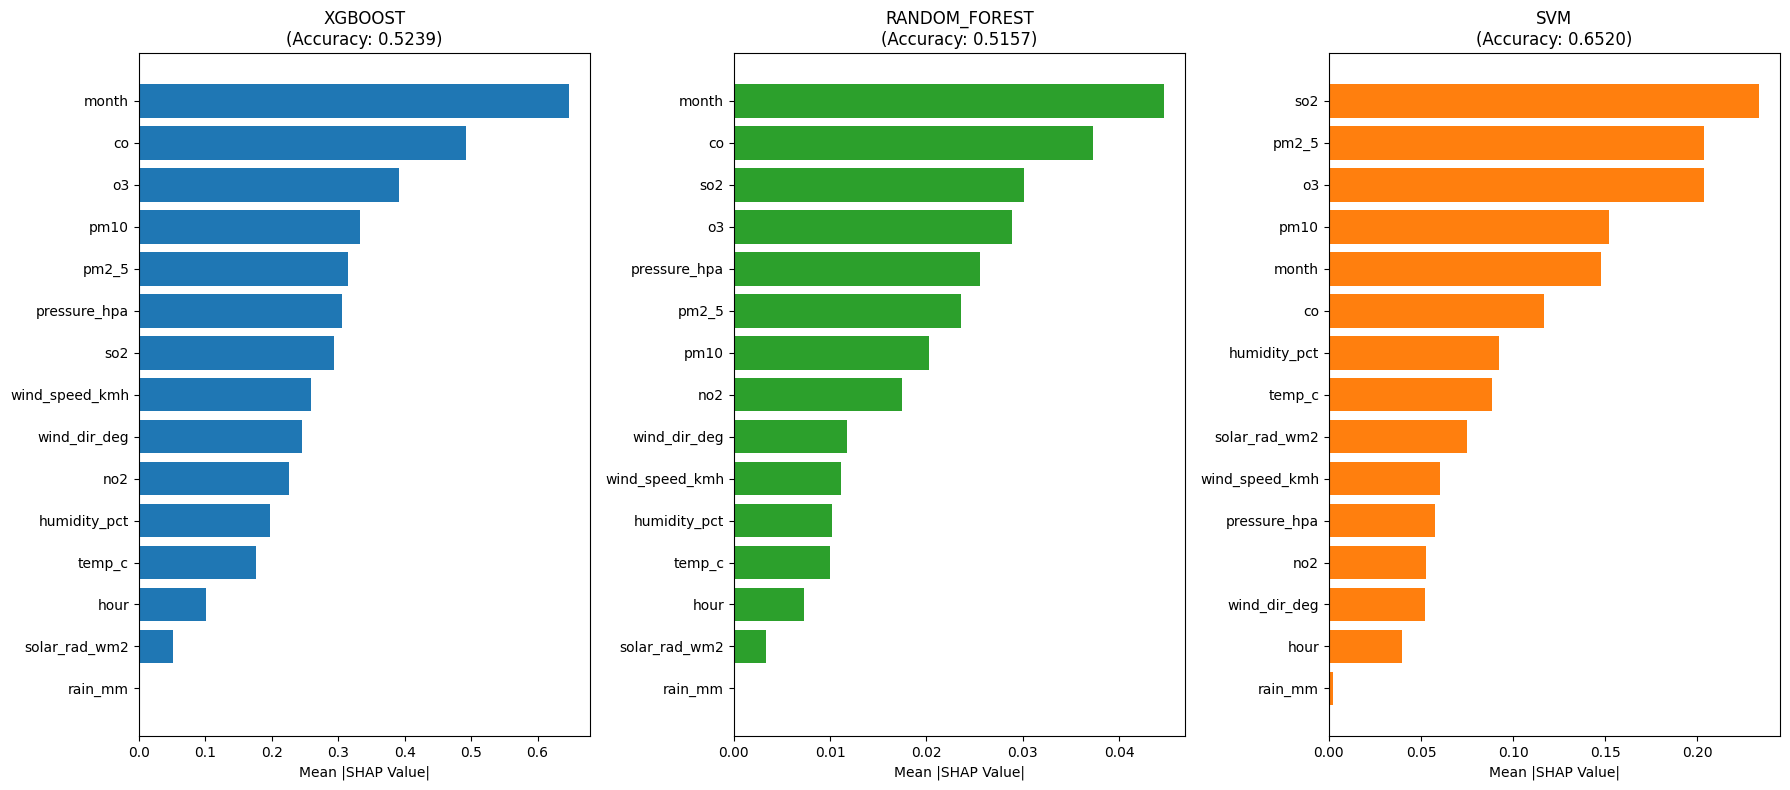

In [10]:
# Bar plots for each model
n_models = len(shap_results)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
if n_models == 1:
    axes = [axes]

colors = {'xgboost': '#1f77b4', 'random_forest': '#2ca02c', 'svm': '#ff7f0e'}

for idx, (model_type, results) in enumerate(shap_results.items()):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'mean_shap': results['mean_shap']
    }).sort_values('mean_shap', ascending=True)
    
    axes[idx].barh(importance_df['feature'], importance_df['mean_shap'], 
                   color=colors.get(model_type, 'steelblue'))
    axes[idx].set_xlabel('Mean |SHAP Value|', fontsize=10)
    axes[idx].set_title(f"{model_type.upper()}\n(Accuracy: {results['accuracy']:.4f})", fontsize=12)

plt.tight_layout()
plt.savefig('../docs/shap_importance_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Waterfall Plot (Single Prediction Explanation)
Shows how each feature contributes to a single prediction for the best model.

Using best model: SVM (Accuracy: 0.6520)
Predicted AQI Class: 4
SHAP values shape: (15,)
Base value: 3.829999999999999


/home/hypxr/Repositories/AQI-Predictor/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


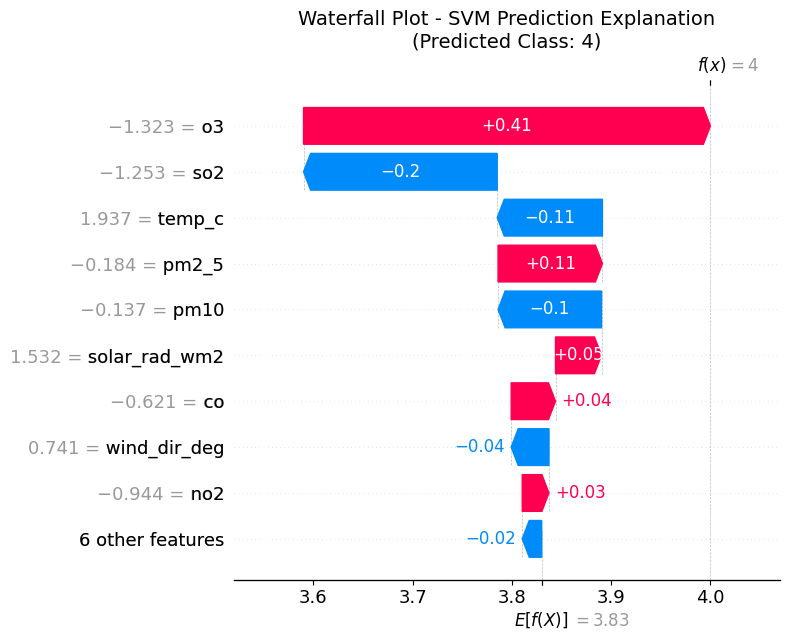

In [11]:
# Use the best performing model for waterfall plot
best_model_type = max(shap_results.keys(), key=lambda k: shap_results[k]['accuracy'])
best_results = shap_results[best_model_type]
best_model = models[best_model_type]['model']

print(f"Using best model: {best_model_type.upper()} (Accuracy: {best_results['accuracy']:.4f})")

# Explain a single prediction
sample_idx = 0
shap_values = best_results['shap_values']
explainer = best_results['explainer']

# Get predicted class
pred_class = int(best_model.predict(X_sample.iloc[[sample_idx]])[0])
print(f"Predicted AQI Class: {pred_class}")

# Get the SHAP values for this sample
if isinstance(shap_values, list):
    # Multi-class: shap_values is a list of arrays, one per class
    # Each array has shape (n_samples, n_features)
    sv = shap_values[pred_class][sample_idx]  # 1D array of shape (n_features,)
    base_value = explainer.expected_value[pred_class]
else:
    # Check if it's a 3D array (n_samples, n_features, n_classes)
    if shap_values.ndim == 3:
        sv = shap_values[sample_idx, :, pred_class]  # Select sample and class
        if hasattr(explainer.expected_value, '__iter__'):
            base_value = explainer.expected_value[pred_class]
        else:
            base_value = explainer.expected_value
    elif shap_values.ndim == 2:
        # Could be (n_samples, n_features) or (n_features, n_classes)
        if shap_values.shape[0] == len(X_sample):
            sv = shap_values[sample_idx]  # (n_samples, n_features) -> select sample
        else:
            sv = shap_values[:, pred_class] if shap_values.shape[1] > 1 else shap_values.flatten()
        base_value = explainer.expected_value if not hasattr(explainer.expected_value, '__iter__') else explainer.expected_value[pred_class]
    else:
        sv = shap_values[sample_idx]
        base_value = explainer.expected_value

# Ensure sv is 1D
sv = np.array(sv).flatten()
print(f"SHAP values shape: {sv.shape}")
print(f"Base value: {base_value}")

# Create waterfall plot
plt.figure(figsize=(12, 8))
shap.waterfall_plot(shap.Explanation(
    values=sv,
    base_values=float(base_value),
    data=X_sample.iloc[sample_idx].values,
    feature_names=feature_cols
), show=False)
plt.title(f"Waterfall Plot - {best_model_type.upper()} Prediction Explanation\n(Predicted Class: {pred_class})", fontsize=14)
plt.tight_layout()
plt.savefig('../docs/shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.5 Dependence Plots (Top Features)
Shows how top features affect predictions with interaction effects.

Top 4 features: ['month', 'co', 'o3', 'so2']
SHAP values shape: (300, 15)


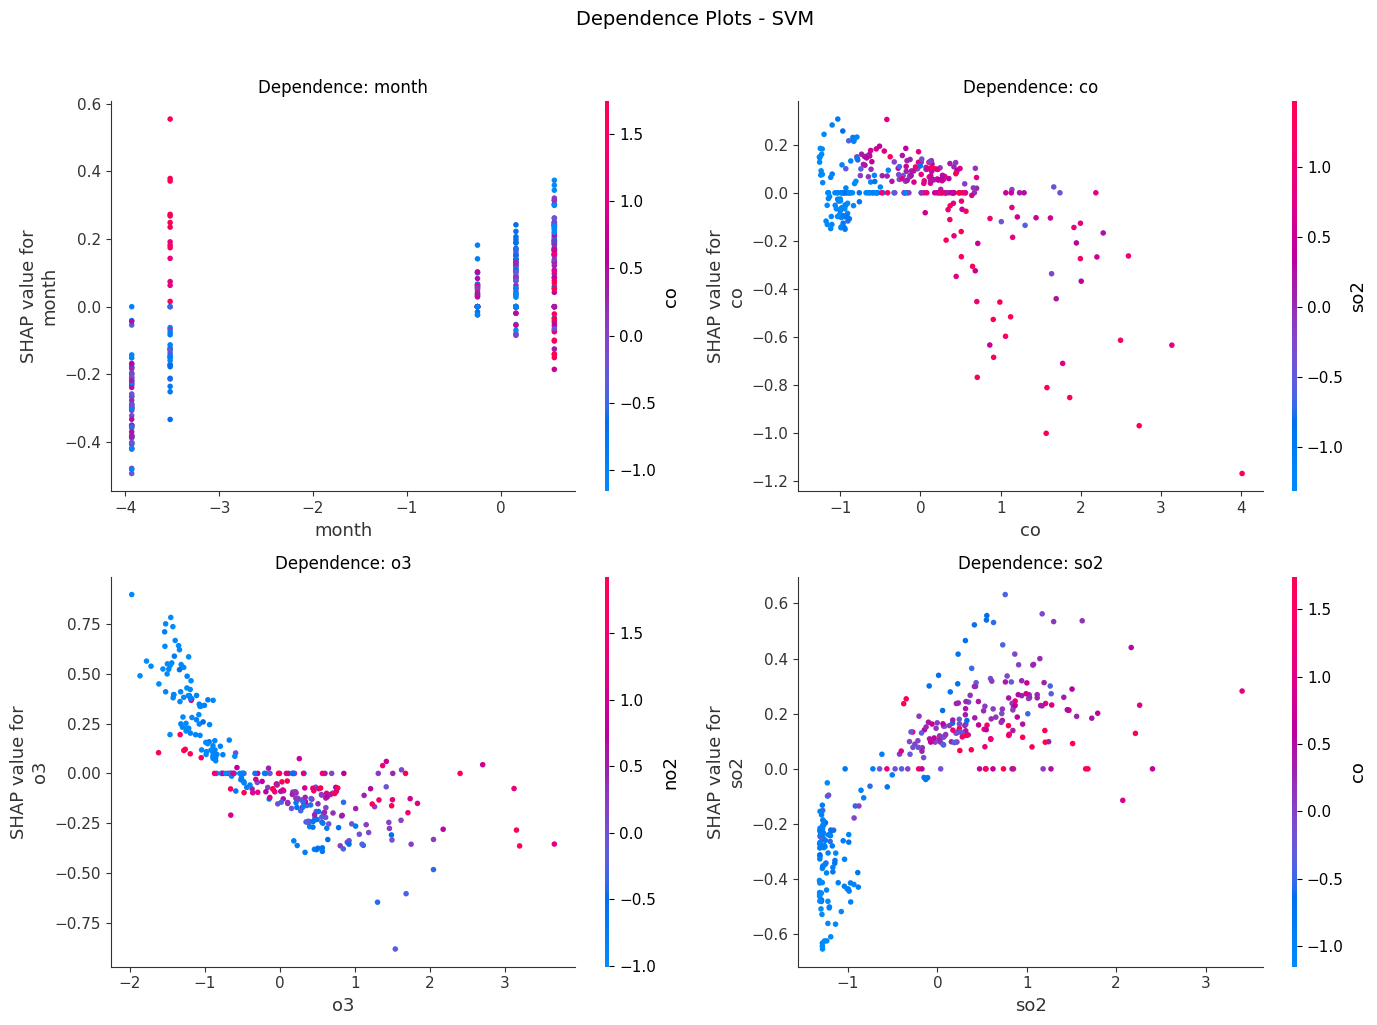

In [12]:
# Top 4 features based on average importance across all models
top_features = comparison_df.sort_values('average', ascending=False)['feature'].head(4).tolist()
print(f"Top 4 features: {top_features}")

# Dependence plots for best model
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

shap_values = best_results['shap_values']

# Get SHAP values in correct shape (n_samples, n_features)
if isinstance(shap_values, list):
    # Multi-class: use one class (e.g., class 2 for "Moderate")
    class_idx = min(2, len(shap_values) - 1)
    sv_for_plot = shap_values[class_idx]  # Shape: (n_samples, n_features)
    print(f"Using class {class_idx} SHAP values, shape: {sv_for_plot.shape}")
elif shap_values.ndim == 3:
    # Shape: (n_samples, n_features, n_classes)
    class_idx = min(2, shap_values.shape[2] - 1)
    sv_for_plot = shap_values[:, :, class_idx]  # Shape: (n_samples, n_features)
    print(f"Using class {class_idx} SHAP values, shape: {sv_for_plot.shape}")
else:
    sv_for_plot = shap_values
    print(f"SHAP values shape: {sv_for_plot.shape}")

# Verify shape matches X_sample
assert sv_for_plot.shape == X_sample.shape, f"Shape mismatch: SHAP {sv_for_plot.shape} vs X_sample {X_sample.shape}"

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(feature, sv_for_plot, X_sample, show=False, ax=axes[idx])
    axes[idx].set_title(f"Dependence: {feature}", fontsize=12)

plt.suptitle(f"Dependence Plots - {best_model_type.upper()}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../docs/shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Key Insights

In [13]:
print("="*70)
print("SHAP ANALYSIS SUMMARY - ALL MODELS")
print("="*70)

print("\n" + "-"*70)
print("MODEL ACCURACIES:")
print("-"*70)
for model_type, results in shap_results.items():
    print(f"  {model_type.upper()}: {results['accuracy']:.4f}")

print("\n" + "-"*70)
print("TOP 5 MOST INFLUENTIAL FEATURES (Average across all models):")
print("-"*70)
top5 = comparison_df.sort_values('average', ascending=False).head(5)
for i, (_, row) in enumerate(top5.iterrows(), 1):
    model_values = " | ".join([f"{mt}: {row[mt]:.4f}" for mt in shap_results.keys()])
    print(f"  {i}. {row['feature']}")
    print(f"     {model_values}")

print("\n" + "-"*70)
print("FEATURE IMPORTANCE AGREEMENT:")
print("-"*70)
# Check if models agree on top features
top3_per_model = {}
for model_type in shap_results.keys():
    top3_per_model[model_type] = comparison_df.nlargest(3, model_type)['feature'].tolist()

print("Top 3 features per model:")
for model_type, features in top3_per_model.items():
    print(f"  {model_type.upper()}: {', '.join(features)}")

# Find common top features
common_top = set(top3_per_model[list(top3_per_model.keys())[0]])
for features in top3_per_model.values():
    common_top &= set(features)
print(f"\nCommon top features: {', '.join(common_top) if common_top else 'None'}")

print("\n" + "-"*70)
print("INTERPRETATION:")
print("-"*70)
print("""
• Higher SHAP values indicate stronger influence on AQI predictions
• Features appearing as important across all models are robust predictors
• Pollutant concentrations typically have highest impact on AQI
• Weather conditions provide contextual information for predictions
• Temporal features capture seasonal and daily patterns
""")

print("\n" + "="*70)
print("Analysis complete! All plots saved to docs/ folder.")
print("="*70)

SHAP ANALYSIS SUMMARY - ALL MODELS

----------------------------------------------------------------------
MODEL ACCURACIES:
----------------------------------------------------------------------
  XGBOOST: 0.5239
  RANDOM_FOREST: 0.5157
  SVM: 0.6520

----------------------------------------------------------------------
TOP 5 MOST INFLUENTIAL FEATURES (Average across all models):
----------------------------------------------------------------------
  1. month
     xgboost: 0.6466 | random_forest: 0.0446 | svm: 0.1475
  2. co
     xgboost: 0.4930 | random_forest: 0.0373 | svm: 0.1169
  3. o3
     xgboost: 0.3923 | random_forest: 0.0288 | svm: 0.2035
  4. so2
     xgboost: 0.2942 | random_forest: 0.0302 | svm: 0.2331
  5. pm2_5
     xgboost: 0.3144 | random_forest: 0.0236 | svm: 0.2037

----------------------------------------------------------------------
FEATURE IMPORTANCE AGREEMENT:
----------------------------------------------------------------------
Top 3 features per model:
  X

## 7. Export Results

In [14]:
# Save feature importance comparison to CSV
comparison_df.to_csv('../docs/shap_feature_importance.csv', index=False)
print("✓ Saved feature importance comparison to docs/shap_feature_importance.csv")

# Create summary statistics
summary = {
    'model': [],
    'accuracy': [],
    'top_feature_1': [],
    'top_feature_2': [],
    'top_feature_3': []
}

for model_type, results in shap_results.items():
    summary['model'].append(model_type)
    summary['accuracy'].append(results['accuracy'])
    top3 = comparison_df.nlargest(3, model_type)['feature'].tolist()
    summary['top_feature_1'].append(top3[0] if len(top3) > 0 else '')
    summary['top_feature_2'].append(top3[1] if len(top3) > 1 else '')
    summary['top_feature_3'].append(top3[2] if len(top3) > 2 else '')

summary_df = pd.DataFrame(summary)
summary_df.to_csv('../docs/shap_model_summary.csv', index=False)
print("✓ Saved model summary to docs/shap_model_summary.csv")

print("\n" + "="*50)
print("FILES GENERATED:")
print("="*50)
print("  1. shap_model_comparison.png - Feature importance comparison")
print("  2. shap_summary_all_models.png - Beeswarm plots")
print("  3. shap_importance_all_models.png - Bar plots")
print("  4. shap_waterfall.png - Single prediction explanation")
print("  5. shap_dependence.png - Feature dependence plots")
print("  6. shap_feature_importance.csv - Importance values")
print("  7. shap_model_summary.csv - Model summary")

✓ Saved feature importance comparison to docs/shap_feature_importance.csv
✓ Saved model summary to docs/shap_model_summary.csv

FILES GENERATED:
  1. shap_model_comparison.png - Feature importance comparison
  2. shap_summary_all_models.png - Beeswarm plots
  3. shap_importance_all_models.png - Bar plots
  4. shap_waterfall.png - Single prediction explanation
  5. shap_dependence.png - Feature dependence plots
  6. shap_feature_importance.csv - Importance values
  7. shap_model_summary.csv - Model summary
